# SymForce PGO

In [1]:
!pip install symforce --quiet
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu

Mount the notebook to our drive so we can load data and import from other python files.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import symforce
try:
  symforce.set_epsilon_to_symbol()
except symforce.AlreadyUsedEpsilon:
  print("Already set symforce epsilon")
  pass

import symforce.symbolic as sf

In [4]:
project_path = '/content/drive/Shareddrives/CS361 Final Project/'

# Add this folder to our path so we can import from python files in it
import sys
sys.path.append(project_path)

# Load the data files
data_path = project_path + 'data/'
odometry_data = np.load(data_path + 'odometry.npz')
gnss_data = np.load(data_path + 'gnss.npz')
ground_truth_data = np.load(data_path + 'ground_truth.npz')

As usual, we extract the numpy arrays stored in the data files. $N$ is the length of the trajectory, $N_{sats}$ is the number of satellites visible throughout the trajectory, which is a constant here.

- `odom_rotations`: array of shape $(N-1)$ x $3$ x $3$ containing $3$ x $3$ rotation matrices at each timestep
- `odom_translations`: array of shape $(N-1)$ x $3$ containing translation vectors at each timestep
- `sv_positions`: array of shape $N$ x $N_{sats}$ x $3$ containing the satellite positions in ENU at each timestep
- `pranges`: array of shape $N$ x $N_{sats}$ containing the pseudoranges from each satellite to the vehicle at each timestep. These pseudoranges are generated by computing true ranges from the satellites to the vehicle ground truth and adding Gaussian noise with standard deviation of 6 m
- `gt_positions`: array of shape $N$ x $3$ containing ground truth vehicle positions for the trajectory.
- `gt_rotations`: array of shape $N$ x $3$ x $3$ containing rotation matrices describing the orientation of the vehicle throughout the trajectory.

In [5]:
# Parameters
N = 4500
N_SATS = 9

In [6]:
odom_rotations = odometry_data['rotations']
odom_translations = odometry_data['translations']
sv_positions = gnss_data['sv_positions'][:N]
pranges = gnss_data['pranges'][:N]
gt_positions = ground_truth_data['translations'][:N]
gt_rotations = ground_truth_data['rotations'][:N]

We extract the odometry data (rotation matrices and translation vectors) into a list of tuples $\{(R_1, t_1), \dots, (R_{N-1}, t_{N-1})\}$, where $(R_i, t_i)$ is the estimated transformation from pose $T_i$ to $T_{i+1}$.

In [7]:
odoms = [] # list of (R, t) tuples
for i in range(N - 1):
  odoms.append((odom_rotations[i], odom_translations[i]))

We plot the ground truth in 2D. We mark the start with a marker and color-code by trajectory index (blue=start, yellow=end) to better visualize the progression from start to end.

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), showlegend=False))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth.png")
fig.show()

We now plot the ground truth in 3D

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=gt_positions[:, 0], y=gt_positions[:, 1], z=gt_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), showlegend=False))
fig.add_trace(go.Scatter3d(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], z=[gt_positions[0, 2]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=1200, height=800, scene_aspectmode='data', title={'text': '3D Ground Truth', 'x': 0.5}, scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)'))
fig.show()

In [10]:
def make_pose(R, t):
  """
  Utility for creating a symforce Pose3 object from a rotation matrix and np vector

  Parameters
  ----------
  R : np.array (3, 3)
      Rotation matrix
  t : np.array (3,)
      Translation vector

  """
  return sf.Pose3(R=sf.Rot3.from_rotation_matrix(R), t=sf.Vector3(t))

## Fusing odometry and ranges with PGO

We will use pose graph optimization (PGO) to solve for the trajectory. To do this we will use the function `tc_pgo` which takes as input a set of initial poses, satellite positions, range measurements, odometry measurements, and builds a SymForce pose graph and optimizes it.
This function uses the `range_residual` and `odometry_residual` functions which define the residuals for the range and odometry factors.

In [11]:
from symforce import typing as T


def range_residual(pose: sf.Pose3, satellite: sf.V3, range: sf.Scalar, sigma: sf.Scalar, epsilon: sf.Scalar) -> sf.V1:
  """
  range residual

  Parameters
  ----------
  pose : sf.Pose3
      Robot pose
  satellite : sf.V3
      Satellite position
  range : sf.Scalar
      Measured range
  sigma : sf.Scalar
      Standard deviation of range measurement
  epsilon : sf.Scalar
      Epsilon for numerical stability

  Returns
  -------
  sf.V1
      Residual
  """
  return sf.V1(((pose.t - satellite).norm(epsilon=epsilon) - range) / sigma)


def odometry_residual(world_T_a: sf.Pose3, world_T_b: sf.Pose3, a_T_b: sf.Pose3, diagonal_sigmas: sf.V6, epsilon: sf.Scalar) -> sf.V6:
  """
  Residual on the relative pose between two timesteps of the robot.
  Args:
      world_T_a: First pose in the world frame
      world_T_b: Second pose in the world frame
      a_T_b: Relative pose measurement between the poses
      diagonal_sigmas: Diagonal standard deviation of the tangent-space error
      epsilon: Small number for singularity handling
  """
  expected_a_T_b = world_T_a.inverse() * world_T_b
  error = expected_a_T_b.inverse() * a_T_b
  error_tangent_space = sf.V6(error.to_tangent(epsilon=epsilon))
  sigmas = sf.M.diag(diagonal_sigmas)
  return sf.V6(sigmas.inv() * error_tangent_space)

We have some helper code for constructing the pose graph and running optimization.

In [12]:
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer


def build_values(init_poses, satpos, m_ranges, m_odometry, sigma_gps, sigma_odom):
  """
  Build values for pose graph
  """
  values = Values()

  values["poses"] = init_poses
  values["satellites"] = satpos

  values["ranges"] = m_ranges.tolist()
  values["odometry"] = [make_pose(R, t) for R, t in m_odometry]

  values["sigma_gps"] = sigma_gps
  values["sigma_odom"] = sigma_odom

  values["epsilon"] = sf.numeric_epsilon

  return values


def build_factors(num_poses, num_satellites, gps_rate=1, fix_first_pose=True):
  """
  Build range and odometry factors
  """
  start_idx = gps_rate if fix_first_pose else 0
  for i in range(start_idx, num_poses, gps_rate):
      for j in range(num_satellites):
          yield Factor(
              residual=range_residual,
              keys=[
                  f"poses[{i}]",
                  f"satellites[{i}][{j}]",
                  f"ranges[{i}][{j}]",
                  "sigma_gps",
                  "epsilon"])

  for i in range(num_poses - 1):
      yield Factor(
          residual=odometry_residual,
          keys=[
              f"poses[{i}]",
              f"poses[{i + 1}]",
              f"odometry[{i}]",
              "sigma_odom",
              "epsilon"])


def tc_pgo(init_pos, sat_pos, m_ranges, m_odom, sigma_gps, sigma_odom, gps_rate, fix_first_pose=True, debug=False):
  """
  Pose graph optimization

  Parameters
  ----------
  init_pos : list
      List of initial poses (sf.Pose3)
  sat_pos : list
      2D list of satellite positions (sf.V3)
  m_ranges : np.array
      Array of measured ranges
  m_odom : list
      List of measured odometry as tuples (R, t)
  sigma_gps : float
      Range measurement standard deviation
  sigma_odom : float
      Odometry measurement standard deviation
  gps_rate : int
      Ratio of odometry to range measurements
  fix_first_pose : bool
      Whether to fix the first pose
  """
  N_POSES = len(init_pos)
  N_SATS = len(sat_pos[0])

  # Build values and factors
  values = build_values(init_pos, sat_pos, m_ranges, m_odom, sigma_gps, sigma_odom)
  factors = build_factors(N_POSES, N_SATS, gps_rate=gps_rate, fix_first_pose=fix_first_pose)

  # Select the keys to optimize - the rest will be held constant
  start_idx = 1 if fix_first_pose else 0
  optimized_keys = [f"poses[{i}]" for i in range(start_idx, N_POSES)]

  # Create the optimizer
  optimizer = Optimizer(
      factors=factors,
      optimized_keys=optimized_keys,
      # Return problem stats for every iteration
      debug_stats=debug,
      # Customize optimizer behavior
      # can adjust these parameters
      params=Optimizer.Params(verbose=debug,
          initial_lambda=1e4,
          iterations=100,
          lambda_down_factor=0.5))

  # Solve and return the result
  result = optimizer.optimize(values)
  return result

### Sliding window optimization

In [13]:
def run_pgo(W, S, sigma_gps, sigma_R, sigma_t, gps_rate=1):
  sigma_odom = np.ones(6)
  sigma_odom[:3] *= sigma_R
  sigma_odom[3:] *= sigma_t

  # Initialize the first W poses as sf.Pose3.identity(), and set the first pose based on ground truth
  init_poses = [sf.Pose3.identity()] * W
  init_poses[0] = make_pose(gt_rotations[0], gt_positions[0])

  # Array to save optimized positions for the entire trajectory
  graph_positions = np.zeros((N, 3))

  # Maximum start index for sliding window
  k_max = (N - W) // S

  # For loop for sliding window optimization
  for k in (pbar := tqdm(range(k_max + 1))):

    # Get indices for current window
    window = slice(k * S, k * S + W)

    # Extract odometry, ranges, and satellite positions for window
    sat_pos = [[sf.V3(pose) for pose in poses] for poses in sv_positions[window]]
    m_odom = odoms[window]
    m_ranges = pranges[window]

    # Run tc_pgo to optimize over the window
    result = tc_pgo(init_poses, sat_pos, m_ranges, m_odom, sigma_gps, sigma_odom, gps_rate)

    # Extract and save positions from window
    poses = [sf.Pose3.from_storage(pose.to_storage()) for pose in result.optimized_values['poses']]
    graph_positions[window] = [pose.t for pose in poses]

    # Update initial poses and use odometry to initialize latest new poses shifted into the window
    if k < k_max:
      init_poses[: W - S] = poses[S:]
      idx = slice(k * S + W - 1, (k + 1) * S + W - 1)
      next_T = [make_pose(R, t) for R, t in odoms[idx]]
      for i in range(S):
        init_poses[W - S + i] = init_poses[W - S + i - 1] * next_T[i]

  graph_RMSE = np.mean(np.linalg.norm(gt_positions[:, :2] - graph_positions[:, :2], axis=1) ** 2) ** 0.5
  return graph_positions, graph_RMSE

We define the same parameters for this PGO, including window size, window shift amount, and measurement standard deviation values.

In [14]:
# Parameters for PGO
W = 60            # Window size for optimization (number of nodes)
S = 30            # Amount to shift window by for each iteration
sigma_gps = 6.0   # Standard deviation of GPS ranges

# Odometry standard deviation
sigma_R = 0.05  # for rotations
sigma_t = 0.01  # for translations [m]

In [15]:
start_time = time.time()
graph_positions, graph_RMSE = run_pgo(W, S, sigma_gps, sigma_R, sigma_t)
end_time = time.time()
total_time = end_time - start_time
print(f"\nFor W = {W} and S = {S}, RMSE: {graph_RMSE} metres and time taken: {total_time} seconds\n")

100%|██████████| 149/149 [10:48<00:00,  4.35s/it]


For W = 60 and S = 30, RMSE: 1.24312038045379 metres and time taken: 648.3335645198822 seconds



In [16]:
x_max_error = np.max(np.abs(gt_positions[:, 0] - graph_positions[:, 0]))
y_max_error = np.max(np.abs(gt_positions[:, 1] - graph_positions[:, 1]))
print(f"Maximum absolute error in x-position: {x_max_error}")
print(f"Maximum absolute error in y-position: {y_max_error}")

Maximum absolute error in x-position: 3.1382756753753966
Maximum absolute error in y-position: 3.8874611600306537


In [17]:
# PGO trajectory plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
fig.add_trace(go.Scatter(x=graph_positions[:, 0], y=graph_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(graph_positions))), name='PGO'))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth and SymForce PGO', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth_and_symforce_PGO_W60_S30.png")
fig.show()

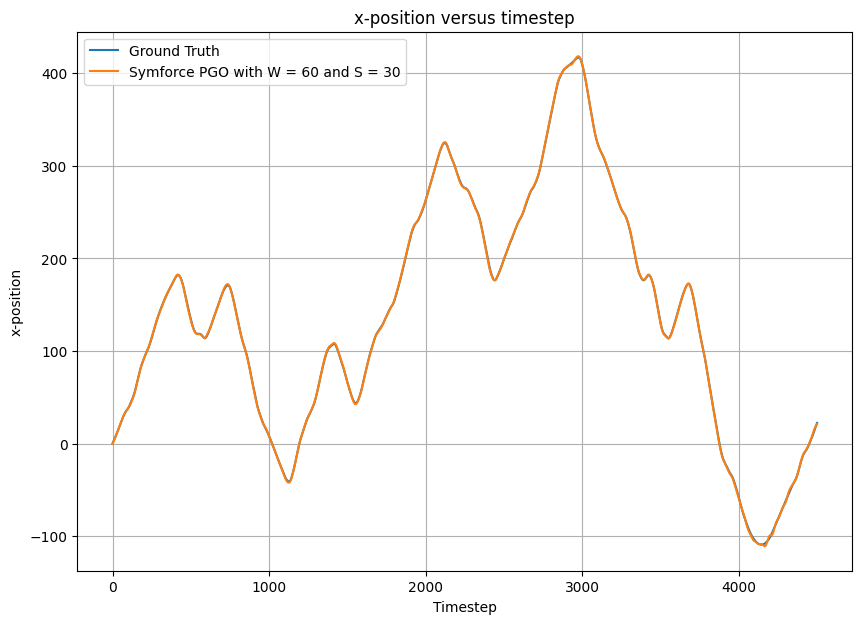

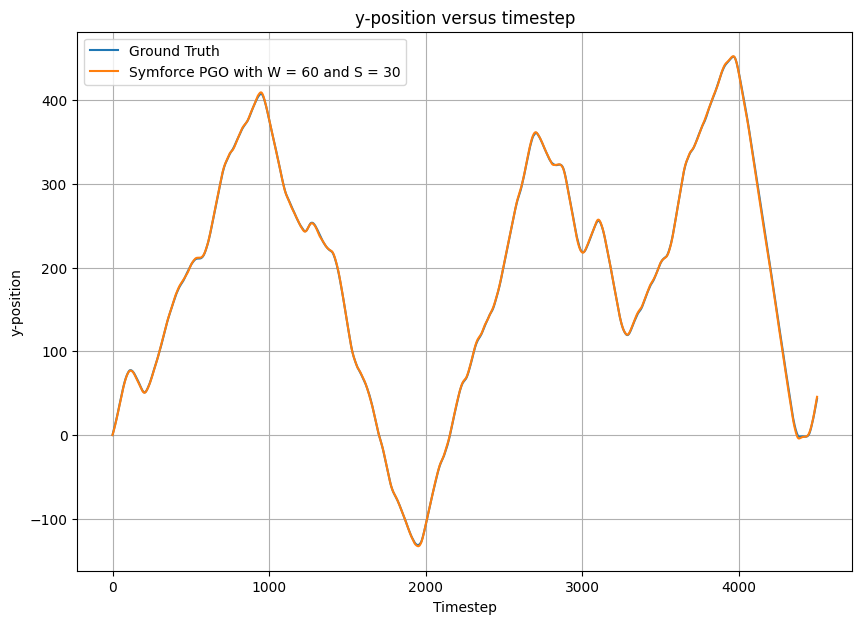

In [18]:
# Plot the x position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 0], label='Ground Truth')
plt.plot(np.arange(N), graph_positions[:, 0], label='Symforce PGO with W = 60 and S = 30')
plt.legend()
plt.title('x-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('x-position')
plt.grid(True)
plt.savefig("x_symforce_pgo_W60S30.png")
plt.show()

# Plot the y position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 1], label='Ground Truth')
plt.plot(np.arange(N), graph_positions[:, 1], label='Symforce PGO with W = 60 and S = 30')
plt.legend()
plt.title('y-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('y-position')
plt.grid(True)
plt.savefig("y_symforce_pgo_W60S30.png")
plt.show()